## Population assignment using Neural Network classification

**Matt DeSaix**

Here, I provide an example of using a neural network classification with an Adam optimizer to assign individuals to population of origin based on genetic variation

In [22]:
# Load in dependencies
import numpy as np
import optimizers
import sys
import NeuralNetworkClassifier as nnc
import pandas
import matplotlib.pyplot as plt

In [15]:
# Read in sample data file
file = '../data/stepping-stone-1000snp-sample-mig_001.gen012.csv'
data = np.loadtxt(file, dtype = int, delimiter=",")

In [16]:
# partition data function, makes sure to split up individuals within each population evenly
def partitionData(data):
    
    trainIDs = []
    testIDs = []
    popIDs = np.unique(data[:,0])
    for pop in popIDs:
        rowIDs = np.where(data[:,0] == pop)[0]
        np.random.shuffle(rowIDs)
        trainIDs = np.append(trainIDs, rowIDs[:50])
        testIDs = np.append(testIDs, rowIDs[50:])
    trainIDs = trainIDs.astype(int)
    testIDs = testIDs.astype(int)
    Xtrain = data[trainIDs, 1:]
    Ttrain = data[trainIDs,0:1]
    Xtest = data[testIDs, 1:]
    Ttest = data[testIDs, 0:1]
    
    # Ttrain = makeIndicatorVars(Ttrain)
    # Ttest = makeIndicatorVars(Ttest)
    
    return Xtrain, Ttrain, Xtest, Ttest

In [17]:
Xtrain, Ttrain, Xtest, Ttest = partitionData(data)

In [19]:
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((250, 1000), (250, 1), (250, 1000), (250, 1))

Cool, all of these shapes look appropriate. The 500 individuals were broken up equally among training and testing, and have 1000 SNPs. The response variable of T has the population designation.

Now, let's run a quick model!

In [20]:
hiddens = [5]
nnet = nnc.NeuralNetworkClassifier(Xtrain.shape[1], hiddens, len(np.unique(Ttrain)))
nnet.train(Xtrain, Ttrain, 100, 0.01, method='adam', verbose=True)

Adam: Epoch 10 Error=0.80695
Adam: Epoch 20 Error=0.85606
Adam: Epoch 30 Error=0.89290
Adam: Epoch 40 Error=0.91713
Adam: Epoch 50 Error=0.93347
Adam: Epoch 60 Error=0.94461
Adam: Epoch 70 Error=0.95210
Adam: Epoch 80 Error=0.95861
Adam: Epoch 90 Error=0.96296
Adam: Epoch 100 Error=0.96631


NeuralNetworkClassifier(1000, [5], 5, 'tanh')

In the plots below I show the overall likelihood which we can see is increasing with each epoch. On the right, the plot shows the actual values of populations (T in blue) compared to the predicted values (Y in orange) from the testing data. Overall, looks pretty good except for lots of variation between Pops 1 and 2 (note the zero-indexed values). We can look at this in more detail with a confusion matrix.

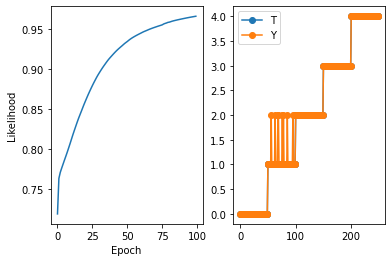

In [23]:
plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(Ttrain, 'o-', label='T')  # to see, when predicted overlap T very closely
plt.plot(nnet.use(Xtrain)[0], 'o-', label='Y')
plt.legend()

In [24]:
def confusion_matrix(predicted, observed):
    table = []
    for true_class in np.unique(observed):
        row = []
        for predicted_class in np.unique(observed):
            row.append(100 * np.mean(predicted[observed == true_class] == predicted_class))
        # row.append(f'{100 * np.mean(Classes[Ttrain == true_class] == predicted_class):0.1f}')
        table.append(row)
        
    class_names = np.unique(observed)
    
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [25]:
confusion_matrix(nnet.use(Xtest)[0], Ttest)

,0,1,2,3,4
0,96.0,4.0,0.0,0.0,0.0
1,0.0,72.0,28.0,0.0,0.0
2,0.0,2.0,96.0,2.0,0.0
3,0.0,0.0,4.0,96.0,0.0
4,0.0,0.0,0.0,0.0,100.0


Interesting, it looks like 28% of individuals from population 1 were being assigned to population 2, while the other populations all had >90% accuracy. Let's compare accuracies for some different model architectures.

In [28]:
import time

def run_experiment(Xtrain, Ttrain, Xtest, Ttest, 
                   n_epochs, learning_rate, 
                   n_hidden_units_per_layer_choices):
    np.random.seed(42)
    results = []
    for nh in n_hidden_units_per_layer_choices:
        for epoch in n_epochs:
            for lr in learning_rate:
                start = time.time()
                # instantiate and train
                nnet = nnc.NeuralNetworkClassifier(Xtrain.shape[1], nh, len(np.unique(Ttrain)))
                nnet.train(Xtrain, Ttrain, epoch, lr, method='adam', verbose=True)
                elapsed = (time.time() - start)
                # append the results of each experiment
                results.append([nh,
                                epoch,
                                lr,
                                (100 * np.mean(nnet.use(Xtrain)[0] == Ttrain)),
                                (100 * np.mean(nnet.use(Xtest)[0] == Ttest)),
                                elapsed])
    # load these into a dataframe and give it some column titles
    df = pandas.DataFrame(results, columns=('Hidden Layers', 'Epochs', 'Learning Rate', 'Train', 'Test', 'Time'))
    return df

In [36]:
result_df = run_experiment(Xtrain, Ttrain, Xtest, Ttest,
                           n_epochs = [100, 1000],
                           learning_rate = [0.01, 0.001],
                           n_hidden_units_per_layer_choices=[[5], [10], [5, 5], [10, 10], [100], [100, 100]])

Adam: Epoch 10 Error=0.82312
Adam: Epoch 20 Error=0.87291
Adam: Epoch 30 Error=0.90755
Adam: Epoch 40 Error=0.92918
Adam: Epoch 50 Error=0.94297
Adam: Epoch 60 Error=0.95211
Adam: Epoch 70 Error=0.95847
Adam: Epoch 80 Error=0.96310
Adam: Epoch 90 Error=0.96660
Adam: Epoch 100 Error=0.96932
Adam: Epoch 10 Error=0.77084
Adam: Epoch 20 Error=0.78063
Adam: Epoch 30 Error=0.78778
Adam: Epoch 40 Error=0.79462
Adam: Epoch 50 Error=0.80160
Adam: Epoch 60 Error=0.80857
Adam: Epoch 70 Error=0.81547
Adam: Epoch 80 Error=0.82214
Adam: Epoch 90 Error=0.82857
Adam: Epoch 100 Error=0.83472
Adam: Epoch 100 Error=0.97699
Adam: Epoch 200 Error=0.99141
Adam: Epoch 300 Error=0.99509
Adam: Epoch 400 Error=0.99673
Adam: Epoch 500 Error=0.99797
Adam: Epoch 600 Error=0.99849
Adam: Epoch 700 Error=0.99883
Adam: Epoch 800 Error=0.99906
Adam: Epoch 900 Error=0.99922
Adam: Epoch 1000 Error=0.99934
Adam: Epoch 100 Error=0.82126
Adam: Epoch 200 Error=0.85466
Adam: Epoch 300 Error=0.87600
Adam: Epoch 400 Error=0.898

In [37]:
result_df

,Hidden Layers,Epochs,Learning Rate,Train,Test,Time
0,[5],100,0.010,98.0,92.0,0.185734
1,[5],100,0.001,98.8,95.2,0.133742
2,[5],1000,0.010,100.0,93.2,1.123600
3,[5],1000,0.001,100.0,92.0,1.144153
4,[10],100,0.010,100.0,92.4,0.132799
5,[10],100,0.001,99.2,93.2,0.134020
6,[10],1000,0.010,100.0,92.4,1.203080
7,[10],1000,0.001,100.0,93.2,1.257135
8,"[5, 5]",100,0.010,97.6,90.8,0.125095
9,"[5, 5]",100,0.001,91.6,81.2,0.132170


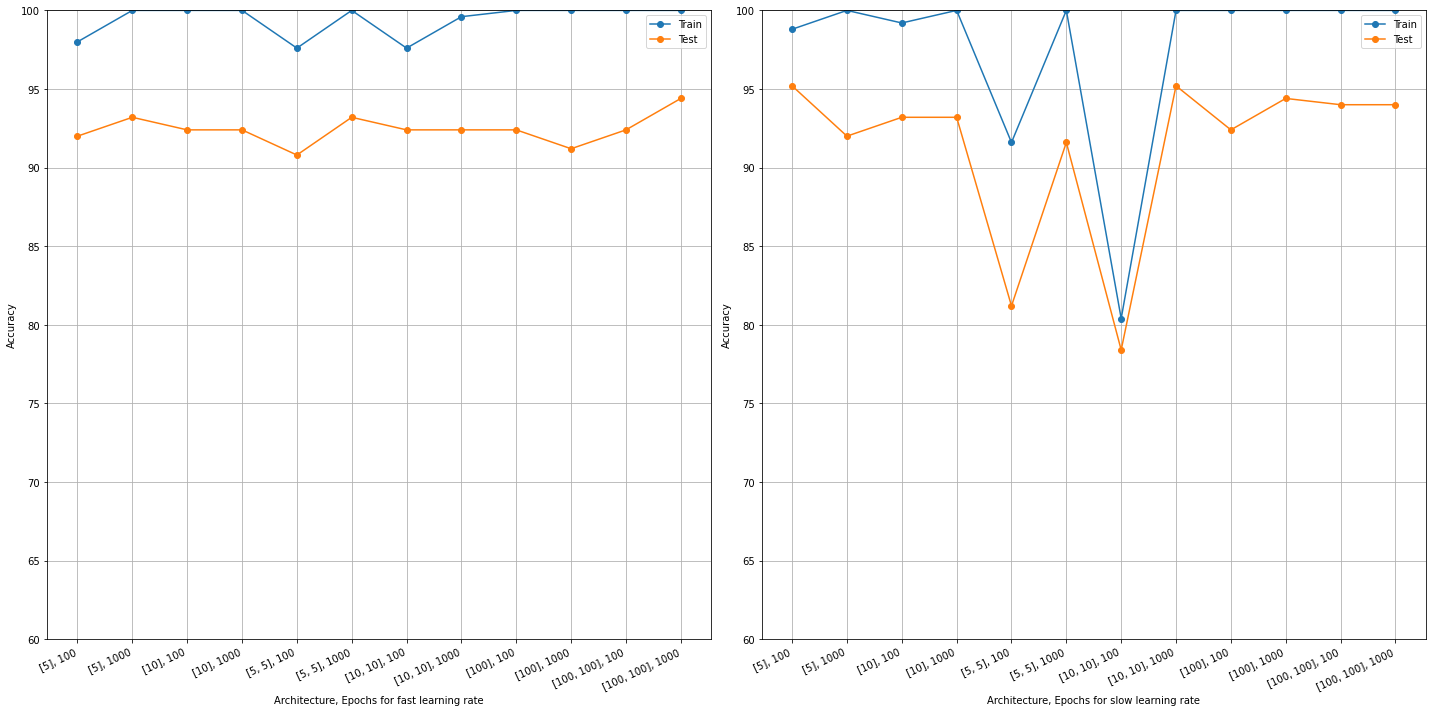

In [43]:
plt.figure(figsize=(20, 10))

# plot results with high migration on the left
plt.subplot(1, 2, 1)
highlr = result_df[(result_df['Learning Rate'] == 0.01)]
xs = range(highlr.shape[0])
plt.plot(xs, highlr[['Train', 'Test']], 'o-')
xticks = highlr[['Hidden Layers', 'Epochs']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Architecture, Epochs for fast learning rate')
plt.ylim(60, 100)
plt.ylabel('Accuracy')
plt.legend(('Train', 'Test'))
plt.grid('on')
    
# plot results with high migration on the left
plt.subplot(1, 2, 2)
lowlr = result_df[(result_df['Learning Rate'] == 0.001)]
xs = range(lowlr.shape[0])
plt.plot(xs, lowlr[['Train', 'Test']], 'o-')
xticks = lowlr[['Hidden Layers', 'Epochs']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Architecture, Epochs for slow learning rate')
plt.ylim(60, 100)
plt.ylabel('Accuracy')
plt.legend(('Train', 'Test'))
plt.grid('on')


plt.tight_layout();